In [1]:
from collections import OrderedDict
from glob import glob
import numpy as np
import pandas as pd
from os.path import join
import re
from sklearn.model_selection import train_test_split
import xarray as xr

import torch
import torch.nn as nn
from torch import Tensor
from torchmetrics.utilities.checks import _check_same_shape
from torchmetrics import Metric
import pytorch_lightning as pl
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

from pismemulator.metrics import AbsoluteError, absolute_error


/home/andy/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class PDDEmulator(pl.LightningModule):
    def __init__(
        self,
        n_parameters: int,
        n_outputs: int,
        hparams,
        *args,
        **kwargs,
    ):
        super().__init__()
        self.save_hyperparameters(hparams)
        n_layers = self.hparams.n_layers
        n_hidden = self.hparams.n_hidden

        if isinstance(n_hidden, int):
            n_hidden = [n_hidden] * (n_layers - 1)

        # Inputs to hidden layer linear transformation
        self.l_first = nn.Linear(n_parameters, n_hidden[0])
        self.norm_first = nn.LayerNorm(n_hidden[0])
        self.dropout_first = nn.Dropout(p=0.0)

        models = []
        for n in range(n_layers - 2):
            models.append(
                nn.Sequential(
                    OrderedDict(
                        [
                            ("Linear", nn.Linear(n_hidden[n], n_hidden[n + 1])),
                            ("LayerNorm", nn.LayerNorm(n_hidden[n + 1])),
                            ("Dropout", nn.Dropout(p=0.1)),
                        ]
                    )
                )
            )
        self.dnn = nn.ModuleList(models)
        self.l_last = nn.Linear(n_hidden[-1], n_outputs)

        self.train_ae = AbsoluteError()
        self.test_ae = AbsoluteError()

    def forward(self, x, add_mean=False):
        # Pass the input tensor through each of our operations

        a = self.l_first(x)
        a = self.norm_first(a)
        a = self.dropout_first(a)
        z = torch.relu(a)

        for dnn in self.dnn:
            a = dnn(z)
            z = torch.relu(a) + z

        return self.l_last(z)


    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = parent_parser.add_argument_group("NNEmulator")
        parser.add_argument("--batch_size", type=int, default=128)
        parser.add_argument("--n_hidden", default=128)
        parser.add_argument("--learning_rate", type=float, default=0.1)

        return parent_parser

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), self.hparams.learning_rate, weight_decay=0.0
        )
        # This is an approximation to Doug's version:
        scheduler = {
            "scheduler": ExponentialLR(optimizer, 0.9975, verbose=True),
        }

        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, f, o, _ = batch
        f_pred = self.forward(x)
        loss = absolute_error(f_pred, f, o)

        return loss

    def validation_step(self, batch, batch_idx):
        x, f, o, o_0 = batch
        f_pred = self.forward(x)

        self.log("train_loss", self.train_ae(f_pred, f, o))
        self.log("test_loss", self.test_ae(f_pred, f, o_0))

        return {"x": x, "f": f, "f_pred": f_pred, "o": o, "o_0": o_0}

    def validation_epoch_end(self, outputs):

        self.log(
            "train_loss",
            self.train_ae,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )
        self.log(
            "test_loss",
            self.test_ae,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )


In [43]:
class TorchPDDModel(torch.nn.modules.Module):
    """

    # Copyright (c) 2013--2018, Julien Seguinot <seguinot@vaw.baug.ethz.ch>
    # GNU General Public License v3.0+ (https://www.gnu.org/licenses/gpl-3.0.txt)

    A positive degree day model for glacier surface mass balance

    Return a callable Positive Degree Day (PDD) model instance.

    Model parameters are held as public attributes, and can be set using
    corresponding keyword arguments at initialization time:

    *pdd_factor_snow* : float
        Positive degree-day factor for snow.
    *pdd_factor_ice* : float
        Positive degree-day factor for ice.
    *refreeze_snow* : float
        Refreezing fraction of melted snow.
    *refreeze_ice* : float
        Refreezing fraction of melted ice.
    *temp_snow* : float
        Temperature at which all precipitation falls as snow.
    *temp_rain* : float
        Temperature at which all precipitation falls as rain.
    *interpolate_rule* : [ 'linear' | 'nearest' | 'zero' |
                           'slinear' | 'quadratic' | 'cubic' ]
        Interpolation rule passed to `scipy.interpolate.interp1d`.
    *interpolate_n*: int
        Number of points used in interpolations.
    """

    def __init__(
        self,
        pdd_factor_snow=3,
        pdd_factor_ice=8,
        refreeze_snow=0.0,
        refreeze_ice=0.0,
        temp_snow=0.0,
        temp_rain=2.0,
        *args,
        **kwargs,
    ):
        super().__init__()

        # set pdd model parameters
        self.pdd_factor_snow = pdd_factor_snow
        self.pdd_factor_ice = pdd_factor_ice
        self.refreeze_snow = refreeze_snow
        self.refreeze_ice = refreeze_ice
        self.temp_snow = temp_snow
        self.temp_rain = temp_rain

    def forward(self, temp, prec):
        """Run the positive degree day model.

        Use temperature, precipitation, and standard deviation of temperature
        to compute the number of positive degree days, accumulation and melt
        surface mass fluxes, and the resulting surface mass balance.

        *temp*: array_like
            Input near-surface air temperature in degrees Celcius.
        *prec*: array_like
            Input precipitation rate in meter per year.
        """

        # ensure numpy arrays
        temp = torch.asarray(temp)
        prec = torch.asarray(prec)

        # compute accumulation and pdd
        accu_rate = self.accu_rate(temp, prec)
        inst_pdd = self.inst_pdd(temp)

        # initialize snow depth, melt and refreeze rates
        snow_depth = torch.zeros_like(temp)
        snow_melt_rate = torch.zeros_like(temp)
        ice_melt_rate = torch.zeros_like(temp)
        snow_refreeze_rate = torch.zeros_like(temp)
        ice_refreeze_rate = torch.zeros_like(temp)

        # snow_depth[:-1] = torch.clone(snow_depth[1:])
        snow_depth = snow_depth + accu_rate
        snow_melt_rate, ice_melt_rate = self.melt_rates(snow_depth, inst_pdd)
        snow_depth = snow_depth - snow_melt_rate

        melt_rate = snow_melt_rate + ice_melt_rate
        snow_refreeze_rate = self.refreeze_snow * snow_melt_rate
        ice_refreeze_rate = self.refreeze_ice * ice_melt_rate
        refreeze_rate = snow_refreeze_rate + ice_refreeze_rate
        runoff_rate = melt_rate - refreeze_rate
        inst_smb = accu_rate - runoff_rate

        # output
        return {
            "temp": temp,
            "prec": prec,
            "pdds": inst_pdd,
            "accu_rate": accu_rate,
            "snow_melt_rate": snow_melt_rate,
            "ice_melt_rate": ice_melt_rate,
            "melt_rate": melt_rate,
            "snow_refreeze_rate": snow_refreeze_rate,
            "ice_refreeze_rate": ice_refreeze_rate,
            "refreeze_rate": refreeze_rate,
            "runoff_rate": runoff_rate,
            "smb_rate": inst_smb,
            "snow_depth": snow_depth,
        }


    def inst_pdd(self, temp):
        """Compute instantaneous positive degree days from temperature.

        Use near-surface air temperature to compute
        positive degree days (effective temperature for melt,
        unit degrees C).

        *temp*: array_like
            Near-surface air temperature in degrees Celcius.
        """

        # compute positive part of temperature everywhere
        pdd = torch.greater(temp, 0) * temp

        # convert to degree-days
        return pdd

    def accu_rate(self, temp, prec):
        """Compute accumulation rate from temperature and precipitation.

        The fraction of precipitation that falls as snow decreases linearly
        from one to zero between temperature thresholds defined by the
        `temp_snow` and `temp_rain` attributes.

        *temp*: array_like
            Near-surface air temperature in degrees Celcius.
        *prec*: array_like
            Precipitation rate in meter per year.
        """

        # compute snow fraction as a function of temperature
        reduced_temp = (self.temp_rain - temp) / (self.temp_rain - self.temp_snow)
        snowfrac = torch.clip(reduced_temp, 0, 1)

        # return accumulation rate
        return snowfrac * prec

    def melt_rates(self, snow, pdd):
        """Compute melt rates from snow precipitation and pdd sum.

        Snow melt is computed from the number of positive degree days (*pdd*)
        and the `pdd_factor_snow` model attribute. If all snow is melted and
        some energy (PDD) remains, ice melt is computed using `pdd_factor_ice`.

        *snow*: array_like
            Snow precipitation rate.
        *pdd*: array_like
            Number of positive degree days.
        """

        # parse model parameters for readability
        ddf_snow = self.pdd_factor_snow / 1e3
        ddf_ice = self.pdd_factor_ice / 1e3

        # compute a potential snow melt
        pot_snow_melt = ddf_snow * pdd

        # effective snow melt can't exceed amount of snow
        snow_melt = torch.minimum(snow, pot_snow_melt)

        # ice melt is proportional to excess snow melt
        ice_melt = (pot_snow_melt - snow_melt) * ddf_ice / ddf_snow

        # return melt rates
        return (snow_melt, ice_melt)


In [44]:
from SALib.sample import saltelli
from pyDOE import lhs
from scipy.stats.distributions import truncnorm, gamma, uniform, randint
method = "lhs"
n_prior_samples = 1000
np.random.seed(2)

distributions = {
    "T": uniform(loc=-20, scale=40),
    "P": uniform(loc=0, scale=1), 
    "f_snow": uniform(
        loc=2.0, scale=4.0
    ), 
    "f_ice": uniform(
        loc=3.0, scale=9
    ),  # uniform between 3 and 3.5  AS16 best value: 3.25
    "refreeze": uniform(loc=0, scale=1.0),  # uniform between 0.25 and 0.95
}
# Names of all the variables
keys = [x for x in distributions.keys()]

# Describe the Problem
problem = {"num_vars": len(keys), "names": keys, "bounds": [[0, 1]] * len(keys)}

# Generate uniform samples (i.e. one unit hypercube)
if method == "saltelli":
    unif_sample = saltelli.sample(problem, n_prior_samples, calc_second_order=False)
elif method == "lhs":
    unif_sample = lhs(len(keys), n_prior_samples)
else:
    print(f"Method {method} not available")

# To hold the transformed variables
dist_sample = np.zeros_like(unif_sample)

# Now transform the unit hypercube to the prescribed distributions
# For each variable, transform with the inverse of the CDF (inv(CDF)=ppf)
for i, key in enumerate(keys):
    dist_sample[:, i] = distributions[key].ppf(unif_sample[:, i])

# Save to CSV file using Pandas DataFrame and to_csv method
header = keys
# Convert to Pandas dataframe, append column headers, output as csv
df = pd.DataFrame(data=dist_sample, columns=header)


In [129]:
    X = []
    Y = []
    for k, row in df.iterrows():   
        m_f_snow = row["f_snow"]
        m_f_ice = row["f_ice"]
        m_refreeze = row["refreeze"]
        m_T = row["T"]
        m_P = row["P"]

        pdd = TorchPDDModel(
            pdd_factor_snow=m_f_snow,
            pdd_factor_ice=m_f_ice,
            refreeze_snow=m_refreeze,
            refreeze_ice=m_refreeze,
        )
        print(m_T)
        result = pdd(m_T, m_P)

        M_train = result["melt_rate"]
        A_train = result["accu_rate"]
        R_train = result["refreeze_rate"]
        B_train = result["smb_rate"]
        print(M_train)
        m_Y = torch.vstack((M_train, A_train, R_train, B_train))
        print(m_Y.shape)
        Y.append(m_Y)
        X.append(torch.from_numpy(np.hstack((m_P, m_T, m_f_snow, m_f_ice, m_refreeze))))

    X_train = torch.vstack(X).type(torch.FloatTensor)
    Y_train = torch.vstack(Y).type(torch.FloatTensor)
    n_samples, n_parameters = X_train.shape
    n_outputs = Y_train.shape[1]


13.234058235896228
tensor([8.5510e+33, 2.5946e-02])
torch.Size([4, 2])
-16.718628980815616
tensor([1.9162e-10, 0.0000e+00])
torch.Size([4, 2])
-6.21080862637073
tensor([1.3607e+21, 0.0000e+00])
torch.Size([4, 2])
-17.110200234463434
tensor([25.7820,  0.0000])
torch.Size([4, 2])
9.482994254829332
tensor([1.0205e-37, 1.7836e-02])
torch.Size([4, 2])
4.269701680479461
tensor([-7.2704e+14,  7.4825e-03])
torch.Size([4, 2])
-10.003178998684355
tensor([0., 0.])
torch.Size([4, 2])
18.29995694448388
tensor([0.0000, 0.0165])
torch.Size([4, 2])
-3.5224883595360694
tensor([2.7356e+17, 0.0000e+00])
torch.Size([4, 2])
19.45730262499592
tensor([1.8935e+02, 2.5689e-02])
torch.Size([4, 2])
-8.597326163373676
tensor([0., 0.])
torch.Size([4, 2])
-2.571722313279686
tensor([4.9686e-18, 0.0000e+00])
torch.Size([4, 2])
5.380625488339483
tensor([0.0000, 0.0150])
torch.Size([4, 2])
-13.919314369512868
tensor([1.3061e+17, 0.0000e+00])
torch.Size([4, 2])
-15.390469043687231
tensor([2.8962e+15, 0.0000e+00])
torch.

tensor([9.5604e-08, 0.0000e+00])
torch.Size([4, 2])
-6.543589491503262
tensor([9885.6797,    0.0000])
torch.Size([4, 2])
-16.243008470548933
tensor([3.7303e+22, 0.0000e+00])
torch.Size([4, 2])
-16.61592945119623
tensor([4.7751, 0.0000])
torch.Size([4, 2])
-3.2202558768989604
tensor([0., 0.])
torch.Size([4, 2])
-15.084052027222858
tensor([1.0892e-05, 0.0000e+00])
torch.Size([4, 2])
-8.70737276953804
tensor([0., 0.])
torch.Size([4, 2])
16.9995467369691
tensor([9.8586e+04, 1.5988e-02])
torch.Size([4, 2])
6.203598540391798
tensor([1.4220e-20, 1.0908e-02])
torch.Size([4, 2])
3.2880187268922683
tensor([0.0000, 0.0254])
torch.Size([4, 2])
19.338301331775824
tensor([0.0000, 0.0209])
torch.Size([4, 2])
13.6042472086314
tensor([9.3853e-06, 9.5001e-03])
torch.Size([4, 2])
-19.1094488588288
tensor([0., 0.])
torch.Size([4, 2])
-14.603753064873864
tensor([2.8289e-22, 0.0000e+00])
torch.Size([4, 2])
-8.985794582542159
tensor([8.7056e-31, 0.0000e+00])
torch.Size([4, 2])
14.255166027684552
tensor([9.26

torch.Size([4, 2])
-12.611683624508498
tensor([0., 0.])
torch.Size([4, 2])
4.866250032093159
tensor([0.0085, 0.0166])
torch.Size([4, 2])
-11.390973135941175
tensor([0.0005, 0.0000])
torch.Size([4, 2])
13.249335472305695
tensor([-2.8447e-39,  1.5188e-02])
torch.Size([4, 2])
-17.01177987900373
tensor([1.1859e-40, 0.0000e+00])
torch.Size([4, 2])
-19.138266190776644
tensor([3.1716e+23, 0.0000e+00])
torch.Size([4, 2])
-3.716664411192241
tensor([0., 0.])
torch.Size([4, 2])
14.958004426887413
tensor([0.0000, 0.0232])
torch.Size([4, 2])
-4.781661198836931
tensor([0., 0.])
torch.Size([4, 2])
15.138868347719296
tensor([2.1621e+24, 2.7274e-02])
torch.Size([4, 2])
18.224434872270557
tensor([0.0000, 0.0133])
torch.Size([4, 2])
-3.5722731882714562
tensor([0., 0.])
torch.Size([4, 2])
-18.57168115317524
tensor([8.1935e-32, 0.0000e+00])
torch.Size([4, 2])
13.667302007991687
tensor([0.0000, 0.0114])
torch.Size([4, 2])
-18.85426754291007
tensor([173.7975,   0.0000])
torch.Size([4, 2])
1.3984930148802768


In [123]:
# Normalize
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)
X_train_norm = (X_train - X_train_mean) / X_train_std
X_train_norm[(torch.isnan(X_train_norm)) | torch.isneginf(X_train_norm) | torch.isinf(X_train_norm)] = 0

In [124]:
print(X_train.shape, Y_train.shape)

torch.Size([1000, 5]) torch.Size([1000, 8])


In [113]:
    import os
    from scipy.stats import dirichlet

    model_index = 0
    torch.manual_seed(0)
    pl.seed_everything(0)
    np.random.seed(model_index)
    emulator_dir = "pddemulator"

    if not os.path.isdir(emulator_dir):
        os.makedirs(emulator_dir)
        os.makedirs(os.path.join(emulator_dir, "emulator"))


Global seed set to 0


In [114]:
# Copyright (C) 2021 Andy Aschwanden, Douglas C Brinkerhoff
#
# This file is part of pism-emulator.
#
# PISM-EMULATOR is free software; you can redistribute it and/or modify it under the
# terms of the GNU General Public License as published by the Free Software
# Foundation; either version 3 of the License, or (at your option) any later
# version.
#
# PISM-EMULATOR is distributed in the hope that it will be useful, but WITHOUT ANY
# WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS
# FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more
# details.
#
# You should have received a copy of the GNU General Public License
# along with PISM; if not, write to the Free Software
# Foundation, Inc., 51 Franklin St, Fifth Floor, Boston, MA  02110-1301  USA

import torch
from torch import Tensor
from torchmetrics.utilities.checks import _check_same_shape
from torchmetrics import Metric


def _absolute_error_update(
    preds: Tensor, target: Tensor, omegas: Tensor) -> Tensor:
    _check_same_shape(preds, target)
    diff = torch.abs(preds - target)
    sum_abs_error = torch.sum(diff * diff, axis=1)
    absolute_error = torch.sum(sum_abs_error * omegas.squeeze())
    return absolute_error


def _absolute_error_compute(absolute_error) -> Tensor:
    return absolute_error


def absolute_error(
    preds: Tensor, target: Tensor, omegas: Tensor
) -> Tensor:
    """
    Computes squared absolute error
    Args:
        preds: estimated labels
        target: ground truth labels
        omegas: weights
        area: area of each cell
    Return:
        Tensor with absolute error
    Example:
        >>> x = torch.tensor([[0, 1, 2, 3], [1, 2, 3, 4]]).T
        >>> y = torch.tensor([[0, 1, 2, 1], [2, 3, 4, 4]]).T
        >>> o = torch.tensor([0.25, 0.25, 0.3, 0.2])
        >>> a = torch.tensor([0.25, 0.25])
        >>> absolute_error(x, y, o, a)
        tensor(0.4000)
    """
    sum_abs_error = _absolute_error_update(preds, target, omegas)
    return _absolute_error_compute(sum_abs_error)


class AbsoluteError(Metric):
    def __init__(self, compute_on_step: bool = True, dist_sync_on_step=False):
        # call `self.add_state`for every internal state that is needed for the metrics computations
        # dist_reduce_fx indicates the function that should be used to reduce
        # state from multiple processes
        super().__init__(
            compute_on_step=compute_on_step, dist_sync_on_step=dist_sync_on_step
        )

        self.add_state("sum_abs_error", default=torch.tensor(0.0), dist_reduce_fx="sum")

    def update(self, preds: Tensor, target: Tensor, omegas: Tensor):
        """
        Update state with predictions and targets, and area.
        Args:
            preds: Predictions from model
            target: Ground truth values
            omegas: Weights
            area: Area of each cell
        """
        sum_abs_error = _absolute_error_update(preds, target, omegas)
        self.sum_abs_error += sum_abs_error

    def compute(self):
        """
        Computes absolute error over state.
        """
        return _absolute_error_compute(self.sum_abs_error)

    @property
    def is_differentiable(self):
        return True


In [115]:
class PDDDataModule(pl.LightningDataModule):
    def __init__(
        self,
        X,
        Y,
        omegas,
        omegas_0,
        batch_size: int = 128,
        train_size: float = 0.9,
        num_workers: int = 0,
    ):
        super().__init__()
        self.X = X
        self.Y = Y
        self.omegas = omegas
        self.omegas_0 = omegas_0
        self.batch_size = batch_size
        self.train_size = train_size
        self.num_workers = num_workers

    def setup(self, stage: str = None):

        all_data = TensorDataset(self.X, self.Y, self.omegas, self.omegas_0)
        self.all_data = all_data

        training_data, val_data = train_test_split(
            all_data, train_size=self.train_size, random_state=0
        )
        self.training_data = training_data
        self.test_data = training_data

        self.val_data = val_data
        train_all_loader = DataLoader(
            dataset=all_data,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
        )
        self.train_all_loader = train_all_loader
        val_all_loader = DataLoader(
            dataset=all_data,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
        )
        self.val_all_loader = val_all_loader
        train_loader = DataLoader(
            dataset=training_data,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
        )
        self.train_loader = train_loader
        self.test_loader = train_loader
        val_loader = DataLoader(
            dataset=val_data,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )
        self.val_loader = val_loader

    def prepare_data(self, **kwargs):
        pass
    
    def train_dataloader(self):
        return self.train_loader

    def validation_dataloader(self):
        return self.val_loader


In [116]:
    print(f"Training model {model_index}")
    omegas = torch.Tensor(dirichlet.rvs(np.ones(n_prior_samples))).T
    omegas = omegas.type(torch.FloatTensor)
    omegas_0 = torch.ones_like(omegas) / len(omegas)
    area = torch.ones_like(omegas)
    train_size = 1.0
    num_workers = 8
    hparams = {"n_layers": 5, "n_hidden": 128, "batch_size": 128, "learning_rate": 0.1}
    
    if train_size == 1.0:
        data_loader = PDDDataModule(X_train_norm, Y_train, omegas, omegas_0, num_workers=num_workers)
    else:
        data_loader = PDDDataModule(
            X_train_norm, Y_train, omegas, omegas_0, train_size=train_size, num_workers=num_workers
        )

    data_loader.setup()
    e = PDDEmulator(
        n_parameters,
        n_outputs,
        hparams,
    )
    trainer = pl.Trainer(
        auto_lr_find=True,
        max_epochs=1000,
        gpus=1,
#        deterministic=True,
        num_sanity_val_steps=0,
    )
    if train_size == 1.0:
        train_loader = data_loader.train_all_loader
        val_loader = data_loader.val_all_loader
    else:
        train_loader = data_loader.train_loader
        val_loader = data_loader.val_loader

        
    # lr_finder = trainer.tuner.lr_find(e, train_loader, val_loader)
    # fig = lr_finder.plot(suggest=True) # Plot
    # fig.show()
    trainer.fit(e, train_loader, val_loader)
    torch.save(e.state_dict(), f"{emulator_dir}/emulator/emulator_{model_index}.h5")


Training model 0


AssertionError: Size mismatch between tensors

In [13]:
class MALASampler(object):
    """
    MALA Sampler

    Author: Douglas C Brinkerhoff, University of Montana
    """

    def __init__(
        self, model, alpha_b=3.0, beta_b=3.0, alpha=0.01, emulator_dir="./emulator"
    ):
        super().__init__()
        self.model = model.eval()
        self.alpha = alpha
        self.alpha_b = alpha_b
        self.beta_b = beta_b
        self.emulator_dir = emulator_dir

    def find_MAP(self, X, X_I, Y_target, X_min, X_max, n_iters=50, print_interval=10):
        print("***********************************************")
        print("***********************************************")
        print("Finding MAP point")
        print("***********************************************")
        print("***********************************************")
        # Line search distances
        alphas = np.logspace(-4, 0, 11)
        # Find MAP point
        for i in range(n_iters):
            log_pi, g, _, Hinv, log_det_Hinv = self.get_log_like_gradient_and_hessian(
                X, X_I, Y_target, X_min, X_max, compute_hessian=True
            )
            p = Hinv @ -g
            alpha_index = np.nanargmin(
                [
                    self.get_log_like_gradient_and_hessian(
                        X + alpha * p, X_I, Y_target, X_min, X_max, compute_hessian=False
                    )
                    .detach()
                    .cpu()
                    .numpy()
                    for alpha in alphas
                ]
            )
            mu = X + alphas[alpha_index] * p
            X.data = mu.data
            if i % print_interval == 0:
                print("===============================================")
                print(f"iter: {i:d}, log(P): {log_pi:.1f}\n")
#                 print(
#                     "".join(
#                         [
#                             f"{key}: {(val * std + mean):.3f}\n"
#                             for key, val, std, mean in zip(
#                                 X_keys,
#                                 X.data.cpu().numpy(),
#                                 X_P_std,
#                                 X_P_mean,
#                             )
#                         ]
#                     )
#                 )
                print(
                    "".join(
                        [
                            f"{key}: {(val):.3f}\n"
                            for key, val in zip(
                                X_keys,
                                X.data.cpu().numpy(),
                            )
                        ]
                    )
                )

                print("===============================================")
        return X

    def V(self, X, X_I, Y_target, X_bar):
        # model result is in log space
        X_IP = torch.hstack((X, X_I))
        Y_pred = self.model(X_IP)
        r = Y_pred - Y_target
        L1 = torch.sum(
            np.log(gamma((nu + 1) / 2.0))
            - np.log(gamma(nu / 2.0))
            - np.log(np.sqrt(np.pi * nu) * sigma_hat)
            - (nu + 1) / 2.0 * torch.log(1 + 1.0 / nu * (r / sigma_hat) ** 2)
        )
        L2 = torch.sum(
            (self.alpha_b - 1) * torch.log(X_bar)
            + (self.beta_b - 1) * torch.log(1 - X_bar)
        )

        return -(self.alpha * L1 + L2)

    def get_log_like_gradient_and_hessian(
        self, X, X_I, Y_target, X_min, X_max, eps=1e-2, compute_hessian=False
    ):

        X_bar = (X - X_min) / (X_max - X_min)
        log_pi = self.V(X, X_I, Y_target, X_bar)
        if compute_hessian:
            g = torch.autograd.grad(log_pi, X, retain_graph=True, create_graph=True)[0]
            H = torch.stack(
                [torch.autograd.grad(e, X, retain_graph=True)[0] for e in g]
            )
            lamda, Q = torch.linalg.eig(H)
            lamda, Q = lamda.type(torch.float), Q.type(torch.float)
            lamda_prime = torch.sqrt(lamda ** 2 + eps)
            lamda_prime_inv = 1.0 / torch.sqrt(lamda ** 2 + eps)
            H = Q @ torch.diag(lamda_prime) @ Q.T
            Hinv = Q @ torch.diag(lamda_prime_inv) @ Q.T
            log_det_Hinv = torch.sum(torch.log(lamda_prime_inv))
            return log_pi, g, H, Hinv, log_det_Hinv
        else:
            return log_pi

    def draw_sample(self, mu, cov, eps=1e-10):
        L = torch.linalg.cholesky(cov + eps * torch.eye(cov.shape[0], device=device))
        return mu + L @ torch.randn(L.shape[0], device=device)

    def get_proposal_likelihood(self, Y, mu, inverse_cov, log_det_cov):
        return -0.5 * log_det_cov - 0.5 * (Y - mu) @ inverse_cov @ (Y - mu)

    def MALA_step(self, X, X_I, Y_target, X_min, X_max, h, local_data=None):
        if local_data is not None:
            pass
        else:
            local_data = self.get_log_like_gradient_and_hessian(
                X, X_I, Y_target, X_min, X_max, compute_hessian=True
            )

        log_pi, _, H, Hinv, log_det_Hinv = local_data

        X_ = self.draw_sample(X, 2 * h * Hinv).detach()
        X_.requires_grad = True

        log_pi_ = self.get_log_like_gradient_and_hessian(
            X_, X_I, Y_target, X_min, X_max, compute_hessian=False
        )

        logq = self.get_proposal_likelihood(X_, X, H / (2 * h), log_det_Hinv)
        logq_ = self.get_proposal_likelihood(X, X_, H / (2 * h), log_det_Hinv)

        log_alpha = -log_pi_ + logq_ + log_pi - logq
        alpha = torch.exp(min(log_alpha, torch.tensor([0.0], device=device)))
        u = torch.rand(1, device=device)
        if u <= alpha and log_alpha != np.inf:
            X.data = X_.data
            local_data = self.get_log_like_gradient_and_hessian(
                X, X_I, Y_target, X_min, X_max, compute_hessian=True
            )
            s = 1
        else:
            s = 0
        return X, local_data, s

    def MALA(
        self,
        X,
        X_I,
        X_min,
        X_max,
        Y_target,
        n_iters=10001,
        h=0.1,
        h_max=1.0,
        acc_target=0.25,
        k=0.01,
        beta=0.99,
        model_index=0,
        save_interval=1000,
        print_interval=50,
    ):
        print("***********************************************")
        print("***********************************************")
        print(
            "Running Metropolis-Adjusted Langevin Algorithm for model index {0}".format(
                model_index
            )
        )
        print("***********************************************")
        print("***********************************************")

        posterior_dir = f"{self.emulator_dir}/posterior_samples/"
        if not os.path.isdir(posterior_dir):
            os.makedirs(posterior_dir)

        local_data = None
        m_vars = []
        acc = acc_target
        print(n_iters)
        for i in range(n_iters):
            X, local_data, s = self.MALA_step(
                X, X_I, Y_target, X_min, X_max, h, local_data=local_data
            )
            m_vars.append(X.detach())
            acc = beta * acc + (1 - beta) * s
            h = min(h * (1 + k * np.sign(acc - acc_target)), h_max)
            if i % print_interval == 0:
                print("===============================================")
                print(
                    "sample: {0:d}, acc. rate: {1:4.2f}, log(P): {2:6.1f}".format(
                        i, acc, local_data[0].item()
                    )
                )
#                 print(
#                     " ".join(
#                         [
#                             f"{key}: {(val * std + mean):.3f}\n"
#                             for key, val, std, mean in zip(
#                                 X_keys,
#                                 X.data.cpu().numpy(),
#                                 X_P_std,
#                                 X_P_mean,
#                             )
#                         ]
#                     )
#                 )
                print(
                    " ".join(
                        [
                            f"{key}: {(val):.3f}\n"
                            for key, val in zip(
                                X_keys,
                                X.data.cpu().numpy(),
                            )
                        ]
                    )
                )

                print("===============================================")

            if i % save_interval == 0:
                print("///////////////////////////////////////////////")
                print("Saving samples for model {0}".format(model_index))
                print("///////////////////////////////////////////////")
                X_posterior = torch.stack(m_vars).cpu().numpy()
                df = pd.DataFrame(
                    data=X_posterior.astype("float32") * X_P_std.cpu().numpy()
                    + X_P_mean.cpu().numpy(),
                    columns=X_keys,
                )
                df.to_csv(
                    posterior_dir + "X_posterior_model_{0}.csv.gz".format(model_index),
                    compression="infer",
                )
        X_posterior = torch.stack(m_vars).cpu().numpy()
        return X_posterior


In [14]:
    from scipy.stats import beta, uniform
    from scipy.special import gamma

    X_keys = keys
    device="cuda"
    nu = 1
    n_iters=100000
    n_draws=100000
    
    f_snow_test = 3.0
    f_ice_test = 8.0
    refreeze_test = 0.0
    
    pdd = TorchPDDModel(
        pdd_factor_snow=f_snow_test,
        pdd_factor_ice=f_ice_test,
        refreeze_snow=refreeze_test,
        refreeze_ice=refreeze_test,
    )
    result = pdd(T_train, P_train, S_train)

    M_test = result["melt"] + 0.01 * np.random.normal(result["melt"].std(), .01 * result["melt"].std(), result["melt"].shape)
    A_test = result["accu"] + 0.01 * np.random.normal(result["accu"].std(), .01 * result["accu"].std(), result["accu"].shape)
    R_test = result["refreeze"] + 0.01 + np.random.normal(result["refreeze"].std(), .01 * result["refreeze"].std(), result["refreeze"].shape)
    B_test = result["smb"] + 0.01 * np.random.normal(result["smb"].std(), .01 * result["smb"].std(), result["smb"].shape)

    M_test = result["melt"] 
    A_test = result["accu"] 
    R_test = result["refreeze"] 
    B_test = result["smb"]


    X_test = torch.from_numpy(np.hstack((T_train.T, P_train.T, S_train.T, np.tile([f_snow_test, f_ice_test, refreeze_test], (T_train.shape[1], 1))))).type(torch.FloatTensor)
#     X_test_mean = X_test.mean(axis=0)
#     X_test_std = X_test.std(axis=0)
    
#     X_test_norm = (X_test - X_test_mean ) / X_test_std
#     X_test_norm[(torch.isnan(X_test_norm)) | torch.isneginf(X_test_norm) | torch.isinf(X_test_norm)] = 0
#     print(X_test)
#     X_I = X_test_norm[:,:-3].to(device)
#     X_P = X_test_norm[:,-3::].to(device)
    
    X_P_mean = X_train_mean[-3::].to(device)
    X_P_std = X_train_std[-3::].to(device)
    
    X_min = X_train_norm.cpu().numpy().min(axis=0)
    X_max = X_train_norm.cpu().numpy().max(axis=0)

    sigma = 0.01

    rho = 1.0 / (1e4**2)
    point_area = 1800 ** 2
    K = point_area * rho
    sigma_hat = np.sqrt(sigma**2 / K**2)

    # Eq 52
    # this is 2.0 in the paper
    alpha_b = 3.0
    beta_b = 3.0
    X_P_prior =  beta.rvs(alpha_b, beta_b, size=(n_draws, 3)) * (X_max[-3:] - X_min[-3:]) + X_min[-3:]
    X_P_prior =  uniform.rvs(0, 1, size=(n_draws, 3)) * (X_max[-3:] - X_min[-3:]) + X_min[-3:]
    X_I_prior = uniform.rvs(0, 1, size=(n_draws, 36)) * (X_max[:-3] - X_min[:-3]) + X_min[:-3]


    X_min = torch.tensor(X_min, dtype=torch.float32, device=device)
    X_max = torch.tensor(X_max, dtype=torch.float32, device=device)

    # Needs
    # alpha_b, beta_b: float
    # alpha: float
    # nu: float
    # gamma
    # sigma_hat
    X_P_0 = torch.tensor(X_P_prior.mean(axis=0),
                         requires_grad=True, dtype=torch.float, device=device)

    X_I_0 = torch.tensor(X_I_prior.mean(axis=0),
                         requires_grad=True, dtype=torch.float, device=device)
    X_I_prior = torch.tensor(X_I_prior, dtype=torch.float, device=device)
    
    X_P_min = X_min[-3:]
    X_P_max = X_max[-3:]
    
    Y_obs = torch.vstack((M_test, A_test, R_test, B_test)).T.type(torch.FloatTensor)
    U_target = Y_obs.to(device)
    


    mala = MALASampler(e.to(device), emulator_dir=emulator_dir)
    X_map = mala.find_MAP(X_P_0, X_I_0, U_target, X_P_min, X_P_max)
    
    # To reproduce the paper, n_iters should be 10^5
    X_posterior = mala.MALA(
        X_map,
        X_I_0,
        X_P_min,
        X_P_max,
        U_target,
        n_iters=n_iters,
        model_index=int(model_index),
        save_interval=1000,
        print_interval=100,
    )


***********************************************
***********************************************
Finding MAP point
***********************************************
***********************************************
iter: 0, log(P): 15.0

f_snow: 0.707
f_ice: 0.646
refreeze: 0.417

iter: 10, log(P): 15.0

f_snow: 0.707
f_ice: 0.646
refreeze: 0.417



/tmp/ipykernel_81170/1465935595.py:106: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Copy.cpp:239.)
  lamda, Q = lamda.type(torch.float), Q.type(torch.float)


iter: 20, log(P): 15.0

f_snow: 0.707
f_ice: 0.646
refreeze: 0.417

iter: 30, log(P): 15.0

f_snow: 0.707
f_ice: 0.646
refreeze: 0.417

iter: 40, log(P): 15.0

f_snow: 0.707
f_ice: 0.646
refreeze: 0.417

***********************************************
***********************************************
Running Metropolis-Adjusted Langevin Algorithm for model index 0
***********************************************
***********************************************
100000
sample: 0, acc. rate: 0.26, log(P):   15.6
f_snow: 0.862
 f_ice: 0.457
 refreeze: 0.102

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 100, acc. rate: 0.48, log(P):   18.8
f_snow: 0.836
 f_ice: 0.869
 refreeze: 1.327

sample: 200, acc. rate: 0.45, log(P):   20.0
f_snow: 0.521
 f_ice: 0.577
 refreeze: -0.526

sample: 300, acc. rate: 0.35, log(P):   15.8
f_snow: 0.476
 f_ice: 0.725
 refreeze: 0.015

sample: 400, acc. rate: 0.33, log(P):   15.8
f

sample: 3700, acc. rate: 0.33, log(P):   18.6
f_snow: 0.704
 f_ice: 1.044
 refreeze: 1.272

sample: 3800, acc. rate: 0.33, log(P):   15.1
f_snow: 0.753
 f_ice: 0.807
 refreeze: 0.369

sample: 3900, acc. rate: 0.28, log(P):   16.5
f_snow: 0.667
 f_ice: 0.215
 refreeze: 0.275

sample: 4000, acc. rate: 0.25, log(P):   15.4
f_snow: 0.720
 f_ice: 0.885
 refreeze: 0.642

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 4100, acc. rate: 0.32, log(P):   19.6
f_snow: 0.941
 f_ice: 1.207
 refreeze: 0.836

sample: 4200, acc. rate: 0.24, log(P):   15.1
f_snow: 0.709
 f_ice: 0.811
 refreeze: 0.333

sample: 4300, acc. rate: 0.30, log(P):   15.1
f_snow: 0.644
 f_ice: 0.770
 refreeze: 0.379

sample: 4400, acc. rate: 0.29, log(P):   16.2
f_snow: 0.842
 f_ice: 0.337
 refreeze: 0.865

sample: 4500, acc. rate: 0.25, log(P):   15.9
f_snow: 0.721
 f_ice: 0.331
 refreeze: 0.798

sample: 4600, acc. rate: 0.33, log(P):   16.0
f_s

sample: 7800, acc. rate: 0.25, log(P):   15.2
f_snow: 0.780
 f_ice: 0.601
 refreeze: 0.123

sample: 7900, acc. rate: 0.29, log(P):   15.5
f_snow: 0.545
 f_ice: 0.594
 refreeze: 0.816

sample: 8000, acc. rate: 0.26, log(P):   15.4
f_snow: 0.860
 f_ice: 0.724
 refreeze: 0.112

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 8100, acc. rate: 0.32, log(P):   16.7
f_snow: 0.551
 f_ice: 1.009
 refreeze: 0.962

sample: 8200, acc. rate: 0.27, log(P):   16.1
f_snow: 0.809
 f_ice: 1.012
 refreeze: 0.143

sample: 8300, acc. rate: 0.29, log(P):   15.4
f_snow: 0.630
 f_ice: 0.791
 refreeze: 0.040

sample: 8400, acc. rate: 0.30, log(P):   15.3
f_snow: 0.893
 f_ice: 0.704
 refreeze: 0.492

sample: 8500, acc. rate: 0.32, log(P):   18.6
f_snow: 0.587
 f_ice: 0.698
 refreeze: -0.484

sample: 8600, acc. rate: 0.30, log(P):   16.8
f_snow: 0.560
 f_ice: 0.890
 refreeze: 1.116

sample: 8700, acc. rate: 0.29, log(P):   15.9
f_

sample: 11900, acc. rate: 0.28, log(P):   15.6
f_snow: 0.525
 f_ice: 0.464
 refreeze: 0.720

sample: 12000, acc. rate: 0.27, log(P):   15.2
f_snow: 0.584
 f_ice: 0.534
 refreeze: 0.256

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 12100, acc. rate: 0.34, log(P):   17.3
f_snow: 0.588
 f_ice: 0.255
 refreeze: 1.057

sample: 12200, acc. rate: 0.29, log(P):   15.1
f_snow: 0.619
 f_ice: 0.530
 refreeze: 0.265

sample: 12300, acc. rate: 0.26, log(P):   15.6
f_snow: 0.900
 f_ice: 0.430
 refreeze: 0.475

sample: 12400, acc. rate: 0.26, log(P):   16.4
f_snow: 0.654
 f_ice: 0.931
 refreeze: -0.176

sample: 12500, acc. rate: 0.25, log(P):   16.1
f_snow: 0.474
 f_ice: 0.652
 refreeze: -0.113

sample: 12600, acc. rate: 0.32, log(P):   17.1
f_snow: 0.836
 f_ice: 0.725
 refreeze: 1.222

sample: 12700, acc. rate: 0.25, log(P):   15.5
f_snow: 0.495
 f_ice: 0.636
 refreeze: 0.162

sample: 12800, acc. rate: 0.30, log(P)

sample: 16000, acc. rate: 0.28, log(P):   16.0
f_snow: 0.610
 f_ice: 0.315
 refreeze: 0.064

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 16100, acc. rate: 0.31, log(P):   18.7
f_snow: 0.851
 f_ice: 0.185
 refreeze: 1.184

sample: 16200, acc. rate: 0.28, log(P):   16.1
f_snow: 0.710
 f_ice: 0.972
 refreeze: 0.860

sample: 16300, acc. rate: 0.30, log(P):   21.9
f_snow: 1.194
 f_ice: 1.051
 refreeze: 0.830

sample: 16400, acc. rate: 0.27, log(P):   16.2
f_snow: 0.582
 f_ice: 0.254
 refreeze: 0.486

sample: 16500, acc. rate: 0.25, log(P):   16.7
f_snow: 1.088
 f_ice: 0.697
 refreeze: 0.658

sample: 16600, acc. rate: 0.26, log(P):   16.0
f_snow: 0.751
 f_ice: 1.032
 refreeze: 0.383

sample: 16700, acc. rate: 0.23, log(P):   16.5
f_snow: 0.729
 f_ice: 0.608
 refreeze: -0.311

sample: 16800, acc. rate: 0.27, log(P):   15.0
f_snow: 0.681
 f_ice: 0.751
 refreeze: 0.326

sample: 16900, acc. rate: 0.23, log(P):

sample: 20100, acc. rate: 0.25, log(P):   16.2
f_snow: 0.456
 f_ice: 0.885
 refreeze: 0.810

sample: 20200, acc. rate: 0.29, log(P):   16.1
f_snow: 0.859
 f_ice: 0.353
 refreeze: 0.829

sample: 20300, acc. rate: 0.22, log(P):   15.2
f_snow: 0.883
 f_ice: 0.631
 refreeze: 0.379

sample: 20400, acc. rate: 0.26, log(P):   16.1
f_snow: 0.716
 f_ice: 0.994
 refreeze: 0.838

sample: 20500, acc. rate: 0.24, log(P):   16.3
f_snow: 0.519
 f_ice: 0.550
 refreeze: 1.037

sample: 20600, acc. rate: 0.30, log(P):   17.3
f_snow: 0.408
 f_ice: 0.362
 refreeze: -0.199

sample: 20700, acc. rate: 0.32, log(P):   16.3
f_snow: 0.460
 f_ice: 0.639
 refreeze: 0.981

sample: 20800, acc. rate: 0.29, log(P):   17.3
f_snow: 0.742
 f_ice: 0.605
 refreeze: -0.408

sample: 20900, acc. rate: 0.26, log(P):   18.9
f_snow: 0.316
 f_ice: 0.314
 refreeze: 1.098

sample: 21000, acc. rate: 0.24, log(P):   15.1
f_snow: 0.613
 f_ice: 0.717
 refreeze: 0.538

///////////////////////////////////////////////
Saving samples for m

sample: 24200, acc. rate: 0.27, log(P):   16.2
f_snow: 0.396
 f_ice: 0.637
 refreeze: 0.064

sample: 24300, acc. rate: 0.25, log(P):   16.2
f_snow: 0.673
 f_ice: 0.405
 refreeze: 1.013

sample: 24400, acc. rate: 0.21, log(P):   15.0
f_snow: 0.630
 f_ice: 0.635
 refreeze: 0.390

sample: 24500, acc. rate: 0.31, log(P):   16.3
f_snow: 0.519
 f_ice: 0.361
 refreeze: -0.084

sample: 24600, acc. rate: 0.31, log(P):   16.7
f_snow: 0.802
 f_ice: 1.073
 refreeze: 0.808

sample: 24700, acc. rate: 0.29, log(P):   19.9
f_snow: 0.254
 f_ice: 1.052
 refreeze: 0.609

sample: 24800, acc. rate: 0.32, log(P):   15.4
f_snow: 0.786
 f_ice: 0.566
 refreeze: 0.824

sample: 24900, acc. rate: 0.28, log(P):   18.2
f_snow: 0.263
 f_ice: 0.597
 refreeze: 0.315

sample: 25000, acc. rate: 0.26, log(P):   16.1
f_snow: 0.676
 f_ice: 0.258
 refreeze: 0.210

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 25100, acc. rate: 0.31, log(P):

sample: 28300, acc. rate: 0.27, log(P):   15.0
f_snow: 0.677
 f_ice: 0.595
 refreeze: 0.535

sample: 28400, acc. rate: 0.33, log(P):   16.5
f_snow: 0.447
 f_ice: 0.430
 refreeze: -0.117

sample: 28500, acc. rate: 0.31, log(P):   16.4
f_snow: 0.748
 f_ice: 0.951
 refreeze: -0.158

sample: 28600, acc. rate: 0.29, log(P):   18.3
f_snow: 0.851
 f_ice: 0.780
 refreeze: 1.311

sample: 28700, acc. rate: 0.27, log(P):   15.8
f_snow: 0.777
 f_ice: 0.310
 refreeze: 0.488

sample: 28800, acc. rate: 0.29, log(P):   16.1
f_snow: 0.467
 f_ice: 0.363
 refreeze: 0.192

sample: 28900, acc. rate: 0.23, log(P):   15.7
f_snow: 0.675
 f_ice: 0.487
 refreeze: -0.100

sample: 29000, acc. rate: 0.28, log(P):   18.5
f_snow: 0.740
 f_ice: 0.867
 refreeze: -0.471

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 29100, acc. rate: 0.25, log(P):   17.0
f_snow: 0.997
 f_ice: 0.253
 refreeze: 0.248

sample: 29200, acc. rate: 0.28, log(

sample: 32400, acc. rate: 0.29, log(P):   15.5
f_snow: 0.771
 f_ice: 0.928
 refreeze: 0.606

sample: 32500, acc. rate: 0.34, log(P):   15.6
f_snow: 0.758
 f_ice: 0.881
 refreeze: 0.078

sample: 32600, acc. rate: 0.29, log(P):   15.8
f_snow: 0.840
 f_ice: 0.977
 refreeze: 0.512

sample: 32700, acc. rate: 0.31, log(P):   16.7
f_snow: 0.496
 f_ice: 0.483
 refreeze: -0.262

sample: 32800, acc. rate: 0.28, log(P):   15.4
f_snow: 0.807
 f_ice: 0.717
 refreeze: 0.795

sample: 32900, acc. rate: 0.30, log(P):   16.8
f_snow: 1.066
 f_ice: 0.384
 refreeze: 0.537

sample: 33000, acc. rate: 0.31, log(P):   15.9
f_snow: 0.468
 f_ice: 0.421
 refreeze: 0.645

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 33100, acc. rate: 0.27, log(P):   15.8
f_snow: 0.475
 f_ice: 0.413
 refreeze: 0.321

sample: 33200, acc. rate: 0.29, log(P):   18.8
f_snow: 0.310
 f_ice: 0.189
 refreeze: 0.264

sample: 33300, acc. rate: 0.25, log(P):

sample: 36500, acc. rate: 0.29, log(P):   15.3
f_snow: 0.846
 f_ice: 0.642
 refreeze: 0.153

sample: 36600, acc. rate: 0.24, log(P):   16.5
f_snow: 1.051
 f_ice: 0.618
 refreeze: 0.769

sample: 36700, acc. rate: 0.30, log(P):   16.2
f_snow: 0.557
 f_ice: 0.996
 refreeze: 0.743

sample: 36800, acc. rate: 0.34, log(P):   15.3
f_snow: 0.739
 f_ice: 0.428
 refreeze: 0.292

sample: 36900, acc. rate: 0.25, log(P):   16.3
f_snow: 0.576
 f_ice: 0.608
 refreeze: -0.248

sample: 37000, acc. rate: 0.31, log(P):   15.7
f_snow: 0.513
 f_ice: 0.728
 refreeze: -0.013

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 37100, acc. rate: 0.23, log(P):   16.2
f_snow: 0.664
 f_ice: 0.838
 refreeze: 1.061

sample: 37200, acc. rate: 0.33, log(P):   15.4
f_snow: 0.545
 f_ice: 0.800
 refreeze: 0.188

sample: 37300, acc. rate: 0.30, log(P):   16.3
f_snow: 0.725
 f_ice: 0.516
 refreeze: 1.095

sample: 37400, acc. rate: 0.34, log(P)

sample: 40600, acc. rate: 0.30, log(P):   15.5
f_snow: 0.745
 f_ice: 0.367
 refreeze: 0.348

sample: 40700, acc. rate: 0.23, log(P):   17.4
f_snow: 0.503
 f_ice: 1.006
 refreeze: -0.244

sample: 40800, acc. rate: 0.23, log(P):   15.5
f_snow: 0.775
 f_ice: 0.922
 refreeze: 0.441

sample: 40900, acc. rate: 0.31, log(P):   16.2
f_snow: 0.372
 f_ice: 0.599
 refreeze: 0.436

sample: 41000, acc. rate: 0.33, log(P):   16.1
f_snow: 0.978
 f_ice: 0.929
 refreeze: 0.570

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 41100, acc. rate: 0.24, log(P):   16.6
f_snow: 0.868
 f_ice: 0.976
 refreeze: 0.997

sample: 41200, acc. rate: 0.24, log(P):   19.0
f_snow: 0.260
 f_ice: 0.501
 refreeze: 0.908

sample: 41300, acc. rate: 0.30, log(P):   17.1
f_snow: 0.547
 f_ice: 0.337
 refreeze: 1.099

sample: 41400, acc. rate: 0.22, log(P):   15.7
f_snow: 0.717
 f_ice: 0.817
 refreeze: -0.094

sample: 41500, acc. rate: 0.28, log(P)

sample: 44700, acc. rate: 0.26, log(P):   16.2
f_snow: 0.822
 f_ice: 1.036
 refreeze: 0.614

sample: 44800, acc. rate: 0.29, log(P):   18.6
f_snow: 1.142
 f_ice: 1.026
 refreeze: 0.548

sample: 44900, acc. rate: 0.28, log(P):   15.3
f_snow: 0.536
 f_ice: 0.541
 refreeze: 0.327

sample: 45000, acc. rate: 0.26, log(P):   15.6
f_snow: 0.622
 f_ice: 0.344
 refreeze: 0.515

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 45100, acc. rate: 0.31, log(P):   15.6
f_snow: 0.657
 f_ice: 0.324
 refreeze: 0.431

sample: 45200, acc. rate: 0.34, log(P):   15.4
f_snow: 0.755
 f_ice: 0.413
 refreeze: 0.641

sample: 45300, acc. rate: 0.32, log(P):   17.2
f_snow: 1.039
 f_ice: 0.298
 refreeze: 0.101

sample: 45400, acc. rate: 0.27, log(P):   18.1
f_snow: 0.691
 f_ice: 1.146
 refreeze: -0.168

sample: 45500, acc. rate: 0.26, log(P):   17.8
f_snow: 0.314
 f_ice: 0.797
 refreeze: 0.978

sample: 45600, acc. rate: 0.26, log(P):

sample: 48800, acc. rate: 0.23, log(P):   15.8
f_snow: 0.468
 f_ice: 0.629
 refreeze: 0.019

sample: 48900, acc. rate: 0.24, log(P):   15.5
f_snow: 0.715
 f_ice: 0.831
 refreeze: 0.834

sample: 49000, acc. rate: 0.26, log(P):   15.2
f_snow: 0.787
 f_ice: 0.469
 refreeze: 0.418

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 49100, acc. rate: 0.25, log(P):   15.1
f_snow: 0.614
 f_ice: 0.690
 refreeze: 0.323

sample: 49200, acc. rate: 0.26, log(P):   15.9
f_snow: 0.896
 f_ice: 0.448
 refreeze: -0.024

sample: 49300, acc. rate: 0.31, log(P):   15.4
f_snow: 0.543
 f_ice: 0.816
 refreeze: 0.609

sample: 49400, acc. rate: 0.27, log(P):   16.4
f_snow: 1.022
 f_ice: 0.423
 refreeze: 0.130

sample: 49500, acc. rate: 0.26, log(P):   15.5
f_snow: 0.600
 f_ice: 0.760
 refreeze: 0.834

sample: 49600, acc. rate: 0.29, log(P):   15.6
f_snow: 0.750
 f_ice: 0.334
 refreeze: 0.294

sample: 49700, acc. rate: 0.29, log(P):

sample: 52900, acc. rate: 0.31, log(P):   15.8
f_snow: 0.788
 f_ice: 0.999
 refreeze: 0.442

sample: 53000, acc. rate: 0.29, log(P):   16.0
f_snow: 0.588
 f_ice: 0.599
 refreeze: 1.017

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 53100, acc. rate: 0.26, log(P):   16.5
f_snow: 0.942
 f_ice: 1.009
 refreeze: 0.175

sample: 53200, acc. rate: 0.23, log(P):   15.1
f_snow: 0.739
 f_ice: 0.686
 refreeze: 0.673

sample: 53300, acc. rate: 0.29, log(P):   18.1
f_snow: 1.086
 f_ice: 0.489
 refreeze: -0.280

sample: 53400, acc. rate: 0.29, log(P):   16.0
f_snow: 1.023
 f_ice: 0.577
 refreeze: 0.269

sample: 53500, acc. rate: 0.27, log(P):   15.4
f_snow: 0.569
 f_ice: 0.425
 refreeze: 0.482

sample: 53600, acc. rate: 0.29, log(P):   16.9
f_snow: 0.371
 f_ice: 0.517
 refreeze: 0.939

sample: 53700, acc. rate: 0.28, log(P):   17.9
f_snow: 0.951
 f_ice: 0.257
 refreeze: -0.264

sample: 53800, acc. rate: 0.28, log(P)

sample: 57000, acc. rate: 0.27, log(P):   16.5
f_snow: 0.682
 f_ice: 0.210
 refreeze: 0.534

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 57100, acc. rate: 0.28, log(P):   17.2
f_snow: 0.302
 f_ice: 0.577
 refreeze: 0.482

sample: 57200, acc. rate: 0.31, log(P):   16.4
f_snow: 0.755
 f_ice: 0.233
 refreeze: 0.161

sample: 57300, acc. rate: 0.28, log(P):   15.0
f_snow: 0.699
 f_ice: 0.581
 refreeze: 0.486

sample: 57400, acc. rate: 0.26, log(P):   15.5
f_snow: 0.928
 f_ice: 0.634
 refreeze: 0.658

sample: 57500, acc. rate: 0.26, log(P):   16.6
f_snow: 0.809
 f_ice: 1.024
 refreeze: -0.076

sample: 57600, acc. rate: 0.27, log(P):   15.6
f_snow: 0.570
 f_ice: 0.363
 refreeze: 0.382

sample: 57700, acc. rate: 0.30, log(P):   16.2
f_snow: 0.749
 f_ice: 1.041
 refreeze: 0.686

sample: 57800, acc. rate: 0.33, log(P):   15.8
f_snow: 0.493
 f_ice: 0.480
 refreeze: 0.798

sample: 57900, acc. rate: 0.31, log(P):

sample: 61100, acc. rate: 0.25, log(P):   16.5
f_snow: 0.417
 f_ice: 0.310
 refreeze: 0.413

sample: 61200, acc. rate: 0.32, log(P):   18.0
f_snow: 0.541
 f_ice: 1.170
 refreeze: 0.603

sample: 61300, acc. rate: 0.30, log(P):   15.2
f_snow: 0.818
 f_ice: 0.732
 refreeze: 0.600

sample: 61400, acc. rate: 0.30, log(P):   15.3
f_snow: 0.523
 f_ice: 0.753
 refreeze: 0.315

sample: 61500, acc. rate: 0.29, log(P):   17.3
f_snow: 0.677
 f_ice: 0.157
 refreeze: 0.650

sample: 61600, acc. rate: 0.27, log(P):   15.1
f_snow: 0.738
 f_ice: 0.666
 refreeze: 0.638

sample: 61700, acc. rate: 0.24, log(P):   16.0
f_snow: 0.676
 f_ice: 1.020
 refreeze: 0.572

sample: 61800, acc. rate: 0.30, log(P):   16.4
f_snow: 0.675
 f_ice: 0.650
 refreeze: 1.137

sample: 61900, acc. rate: 0.29, log(P):   20.6
f_snow: 0.473
 f_ice: 1.225
 refreeze: 0.116

sample: 62000, acc. rate: 0.31, log(P):   16.7
f_snow: 0.338
 f_ice: 0.509
 refreeze: 0.439

///////////////////////////////////////////////
Saving samples for mod

sample: 65200, acc. rate: 0.34, log(P):   15.4
f_snow: 0.900
 f_ice: 0.601
 refreeze: 0.663

sample: 65300, acc. rate: 0.24, log(P):   16.5
f_snow: 0.624
 f_ice: 1.085
 refreeze: 0.486

sample: 65400, acc. rate: 0.27, log(P):   15.8
f_snow: 0.724
 f_ice: 0.299
 refreeze: 0.343

sample: 65500, acc. rate: 0.28, log(P):   15.5
f_snow: 0.560
 f_ice: 0.683
 refreeze: 0.844

sample: 65600, acc. rate: 0.26, log(P):   16.9
f_snow: 0.588
 f_ice: 1.045
 refreeze: 0.976

sample: 65700, acc. rate: 0.27, log(P):   16.1
f_snow: 0.507
 f_ice: 0.310
 refreeze: 0.546

sample: 65800, acc. rate: 0.28, log(P):   16.7
f_snow: 0.775
 f_ice: 0.467
 refreeze: 1.152

sample: 65900, acc. rate: 0.26, log(P):   15.5
f_snow: 0.955
 f_ice: 0.705
 refreeze: 0.455

sample: 66000, acc. rate: 0.28, log(P):   16.6
f_snow: 0.414
 f_ice: 0.633
 refreeze: 0.999

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 66100, acc. rate: 0.27, log(P): 

sample: 69300, acc. rate: 0.27, log(P):   15.4
f_snow: 0.701
 f_ice: 0.512
 refreeze: 0.004

sample: 69400, acc. rate: 0.23, log(P):   15.1
f_snow: 0.799
 f_ice: 0.644
 refreeze: 0.637

sample: 69500, acc. rate: 0.27, log(P):   15.3
f_snow: 0.590
 f_ice: 0.497
 refreeze: 0.188

sample: 69600, acc. rate: 0.31, log(P):   17.1
f_snow: 1.056
 f_ice: 0.533
 refreeze: 0.986

sample: 69700, acc. rate: 0.29, log(P):   15.1
f_snow: 0.837
 f_ice: 0.581
 refreeze: 0.373

sample: 69800, acc. rate: 0.31, log(P):   15.5
f_snow: 0.487
 f_ice: 0.568
 refreeze: 0.581

sample: 69900, acc. rate: 0.26, log(P):   15.2
f_snow: 0.752
 f_ice: 0.809
 refreeze: 0.620

sample: 70000, acc. rate: 0.28, log(P):   16.0
f_snow: 0.641
 f_ice: 0.270
 refreeze: 0.231

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 70100, acc. rate: 0.28, log(P):   19.3
f_snow: 0.507
 f_ice: 1.021
 refreeze: -0.456

sample: 70200, acc. rate: 0.27, log(P):

sample: 73400, acc. rate: 0.25, log(P):   15.7
f_snow: 0.479
 f_ice: 0.650
 refreeze: 0.051

sample: 73500, acc. rate: 0.26, log(P):   16.5
f_snow: 1.000
 f_ice: 0.369
 refreeze: 0.063

sample: 73600, acc. rate: 0.27, log(P):   15.3
f_snow: 0.839
 f_ice: 0.535
 refreeze: 0.687

sample: 73700, acc. rate: 0.25, log(P):   15.7
f_snow: 0.655
 f_ice: 0.938
 refreeze: 0.130

sample: 73800, acc. rate: 0.33, log(P):   16.8
f_snow: 0.846
 f_ice: 1.094
 refreeze: 0.166

sample: 73900, acc. rate: 0.23, log(P):   15.1
f_snow: 0.807
 f_ice: 0.767
 refreeze: 0.343

sample: 74000, acc. rate: 0.27, log(P):   15.6
f_snow: 0.802
 f_ice: 0.551
 refreeze: 0.894

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 74100, acc. rate: 0.27, log(P):   15.5
f_snow: 0.680
 f_ice: 0.605
 refreeze: -0.072

sample: 74200, acc. rate: 0.33, log(P):   17.1
f_snow: 0.490
 f_ice: 1.099
 refreeze: 0.628

sample: 74300, acc. rate: 0.27, log(P):

sample: 77500, acc. rate: 0.35, log(P):   17.7
f_snow: 0.316
 f_ice: 0.521
 refreeze: 0.959

sample: 77600, acc. rate: 0.25, log(P):   15.6
f_snow: 0.699
 f_ice: 0.602
 refreeze: -0.100

sample: 77700, acc. rate: 0.26, log(P):   16.8
f_snow: 0.622
 f_ice: 0.286
 refreeze: 1.013

sample: 77800, acc. rate: 0.25, log(P):   16.4
f_snow: 0.557
 f_ice: 1.040
 refreeze: 0.658

sample: 77900, acc. rate: 0.30, log(P):   16.7
f_snow: 0.446
 f_ice: 0.256
 refreeze: 0.492

sample: 78000, acc. rate: 0.29, log(P):   17.4
f_snow: 0.306
 f_ice: 0.446
 refreeze: 0.648

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 78100, acc. rate: 0.34, log(P):   16.1
f_snow: 0.635
 f_ice: 0.646
 refreeze: 1.069

sample: 78200, acc. rate: 0.26, log(P):   15.6
f_snow: 0.695
 f_ice: 0.430
 refreeze: 0.810

sample: 78300, acc. rate: 0.27, log(P):   16.5
f_snow: 1.010
 f_ice: 0.748
 refreeze: 0.956

sample: 78400, acc. rate: 0.32, log(P):

sample: 81600, acc. rate: 0.34, log(P):   17.2
f_snow: 1.006
 f_ice: 0.752
 refreeze: -0.274

sample: 81700, acc. rate: 0.33, log(P):   16.7
f_snow: 0.385
 f_ice: 0.909
 refreeze: 0.079

sample: 81800, acc. rate: 0.29, log(P):   16.4
f_snow: 0.402
 f_ice: 0.879
 refreeze: 0.113

sample: 81900, acc. rate: 0.25, log(P):   15.0
f_snow: 0.732
 f_ice: 0.644
 refreeze: 0.331

sample: 82000, acc. rate: 0.33, log(P):   15.6
f_snow: 0.703
 f_ice: 0.684
 refreeze: 0.931

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 82100, acc. rate: 0.30, log(P):   17.7
f_snow: 0.295
 f_ice: 0.549
 refreeze: 0.829

sample: 82200, acc. rate: 0.25, log(P):   15.7
f_snow: 0.546
 f_ice: 0.582
 refreeze: 0.906

sample: 82300, acc. rate: 0.31, log(P):   15.2
f_snow: 0.817
 f_ice: 0.789
 refreeze: 0.358

sample: 82400, acc. rate: 0.31, log(P):   15.0
f_snow: 0.764
 f_ice: 0.605
 refreeze: 0.377

sample: 82500, acc. rate: 0.36, log(P):

sample: 85700, acc. rate: 0.28, log(P):   16.8
f_snow: 1.075
 f_ice: 0.467
 refreeze: 0.707

sample: 85800, acc. rate: 0.31, log(P):   16.6
f_snow: 1.019
 f_ice: 0.645
 refreeze: 0.981

sample: 85900, acc. rate: 0.26, log(P):   16.1
f_snow: 0.991
 f_ice: 0.726
 refreeze: 0.052

sample: 86000, acc. rate: 0.25, log(P):   16.5
f_snow: 0.608
 f_ice: 1.065
 refreeze: 0.684

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 86100, acc. rate: 0.22, log(P):   15.7
f_snow: 0.956
 f_ice: 0.467
 refreeze: 0.300

sample: 86200, acc. rate: 0.30, log(P):   18.9
f_snow: 1.050
 f_ice: 0.224
 refreeze: -0.276

sample: 86300, acc. rate: 0.29, log(P):   16.1
f_snow: 0.504
 f_ice: 0.409
 refreeze: 0.852

sample: 86400, acc. rate: 0.26, log(P):   15.8
f_snow: 0.478
 f_ice: 0.403
 refreeze: 0.591

sample: 86500, acc. rate: 0.24, log(P):   15.2
f_snow: 0.737
 f_ice: 0.644
 refreeze: 0.733

sample: 86600, acc. rate: 0.19, log(P):

sample: 89800, acc. rate: 0.25, log(P):   16.8
f_snow: 0.351
 f_ice: 0.766
 refreeze: 0.029

sample: 89900, acc. rate: 0.28, log(P):   16.9
f_snow: 0.423
 f_ice: 1.010
 refreeze: 0.081

sample: 90000, acc. rate: 0.30, log(P):   17.6
f_snow: 0.537
 f_ice: 0.190
 refreeze: -0.132

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 90100, acc. rate: 0.25, log(P):   16.0
f_snow: 0.541
 f_ice: 0.299
 refreeze: 0.423

sample: 90200, acc. rate: 0.28, log(P):   16.2
f_snow: 0.582
 f_ice: 0.464
 refreeze: -0.189

sample: 90300, acc. rate: 0.25, log(P):   16.6
f_snow: 0.760
 f_ice: 0.209
 refreeze: 0.231

sample: 90400, acc. rate: 0.29, log(P):   15.0
f_snow: 0.739
 f_ice: 0.671
 refreeze: 0.470

sample: 90500, acc. rate: 0.28, log(P):   16.1
f_snow: 0.769
 f_ice: 1.043
 refreeze: 0.366

sample: 90600, acc. rate: 0.31, log(P):   17.0
f_snow: 0.727
 f_ice: 0.966
 refreeze: -0.289

sample: 90700, acc. rate: 0.23, log(P

sample: 93900, acc. rate: 0.25, log(P):   15.4
f_snow: 0.865
 f_ice: 0.606
 refreeze: 0.724

sample: 94000, acc. rate: 0.25, log(P):   16.7
f_snow: 0.928
 f_ice: 0.823
 refreeze: -0.226

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 94100, acc. rate: 0.26, log(P):   15.6
f_snow: 0.639
 f_ice: 0.579
 refreeze: -0.072

sample: 94200, acc. rate: 0.26, log(P):   15.7
f_snow: 0.742
 f_ice: 0.974
 refreeze: 0.503

sample: 94300, acc. rate: 0.24, log(P):   17.9
f_snow: 1.088
 f_ice: 0.966
 refreeze: 0.948

sample: 94400, acc. rate: 0.26, log(P):   15.9
f_snow: 0.586
 f_ice: 0.559
 refreeze: 0.978

sample: 94500, acc. rate: 0.28, log(P):   15.1
f_snow: 0.735
 f_ice: 0.676
 refreeze: 0.173

sample: 94600, acc. rate: 0.28, log(P):   16.5
f_snow: 0.976
 f_ice: 1.004
 refreeze: 0.458

sample: 94700, acc. rate: 0.24, log(P):   16.0
f_snow: 0.993
 f_ice: 0.642
 refreeze: 0.800

sample: 94800, acc. rate: 0.28, log(P)

sample: 98000, acc. rate: 0.32, log(P):   19.0
f_snow: 1.175
 f_ice: 0.678
 refreeze: 0.203

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 98100, acc. rate: 0.27, log(P):   15.9
f_snow: 0.742
 f_ice: 0.550
 refreeze: -0.188

sample: 98200, acc. rate: 0.28, log(P):   16.1
f_snow: 0.647
 f_ice: 0.374
 refreeze: -0.104

sample: 98300, acc. rate: 0.27, log(P):   17.2
f_snow: 0.933
 f_ice: 1.033
 refreeze: 1.012

sample: 98400, acc. rate: 0.24, log(P):   15.5
f_snow: 0.915
 f_ice: 0.681
 refreeze: 0.118

sample: 98500, acc. rate: 0.27, log(P):   19.2
f_snow: 0.990
 f_ice: 1.195
 refreeze: 0.296

sample: 98600, acc. rate: 0.30, log(P):   15.5
f_snow: 0.551
 f_ice: 0.670
 refreeze: 0.006

sample: 98700, acc. rate: 0.26, log(P):   15.2
f_snow: 0.722
 f_ice: 0.821
 refreeze: 0.294

sample: 98800, acc. rate: 0.23, log(P):   15.2
f_snow: 0.733
 f_ice: 0.841
 refreeze: 0.287

sample: 98900, acc. rate: 0.28, log(P)

In [15]:
X_train.max(axis=0)

torch.return_types.max(
values=tensor([ 5.0000,  5.6699,  7.5000, 10.0000, 12.5000, 14.3301, 15.0000, 14.3301,
        12.5000, 10.0000,  7.5000,  5.6699,  2.0000,  1.8660,  1.5000,  1.0000,
         1.5000,  1.8660,  2.0000,  1.8660,  1.5000,  1.0000,  1.5000,  1.8660,
         0.0000,  0.5359,  2.0000,  4.0000,  6.0000,  7.4641,  8.0000,  7.4641,
         6.0000,  4.0000,  2.0000,  0.5359,  5.9998, 11.9802,  0.9979]),
indices=tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   20,   20,   20,   20,   20,    0,    0,    0,
           0,   20,   20,   20,   20,   20,   20,   20,   20,   20,   20,   20,
        3450, 3825, 1350]))

In [16]:
import numpy as np
import os
from os.path import join

from pathlib import Path

import pandas as pd
import pylab as plt

from matplotlib.ticker import NullFormatter
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D

import seaborn as sns

from scipy.stats import beta, gaussian_kde


In [17]:
X_I_0.shape

torch.Size([36])

Loading posterior samples

  -- pddemulator/posterior_samples/X_posterior_model_0.csv.gz
Merging posteriors into dataframe
Saving figure to pddemulator/posterior.pdf
Saving figure to pddemulator/emulator_posterior.pdf


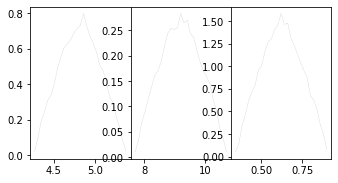

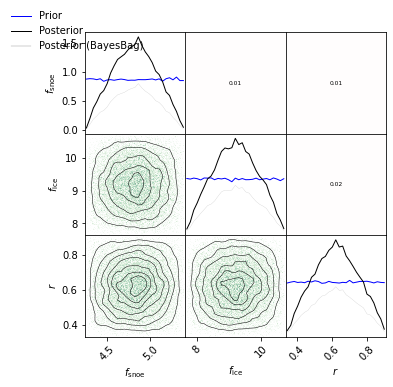

In [18]:
    X_std = X_P_std
    X_mean = X_P_mean
    frac = 1.0
    lw = 1
    color_prior = "b"
    X_list = []
    X_prior = (X_P_prior* X_P_std[-3::] .detach().cpu().numpy() + X_P_mean[-3::] .detach().cpu().numpy())
    keys_dict = {"f_ice": "$f_{\mathrm{ice}}$", "f_snow": "$f_{\mathrm{snoe}}$", "refreeze": "$r$"}
    p = Path(f"{emulator_dir}/posterior_samples/")
    print("Loading posterior samples\n")
    for m, m_file in enumerate(sorted(p.glob("X_posterior_model_*.csv.gz"))):
        print(f"  -- {m_file}")
        df = pd.read_csv(m_file).sample(frac=frac)
        if "Unnamed: 0" in df.columns:
            df.drop(columns=["Unnamed: 0"], inplace=True)
        model = m_file.name.split("_")[-1].split(".")[0]
        df["Model"] = int(model)
        X_list.append(df)

    print(f"Merging posteriors into dataframe")
    posterior_df = pd.concat(X_list)

    X_posterior = posterior_df.drop(columns=["Model"]).values
    C_0 = np.corrcoef((X_posterior - X_posterior.mean(axis=0)).T)
    Cn_0 = (np.sign(C_0) * C_0 ** 2 + 1) / 2.0

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(5.4, 2.8))
    fig.subplots_adjust(hspace=0.0, wspace=0.0)
    for i in range(3):
        min_val = min(X_prior[:, i].min(), X_posterior[:, i].min())
        max_val = max(X_prior[:, i].max(), X_posterior[:, i].max())
        bins = np.linspace(min_val, max_val, 30)
        X_prior_hist, b = np.histogram(X_prior[:, i] , bins, density=True)
        X_posterior_hist, _ = np.histogram(X_posterior[:, i], bins, density=True)
        b = 0.5 * (b[1:] + b[:-1])
        axs[i].plot(
            b,
            X_posterior_hist * 0.5,
            color="0.5",
            linewidth=lw * 0.25,
            linestyle="solid",
            alpha=0.5,
        )

    figfile = f"{emulator_dir}/posterior.pdf"
    print(f"Saving figure to {figfile}")
    fig.savefig(figfile)

    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(5.4, 5.6))
    fig.subplots_adjust(hspace=0.0, wspace=0.0)
    for i in range(3):
        for j in range(3):
            if i > j:

                axs[i, j].scatter(
                    X_posterior[:, j],
                    X_posterior[:, i],
                    c="#31a354",
                    s=0.05,
                    alpha=0.01,
                    label="Posterior",
                    rasterized=True,
                )

                min_val = min(X_prior[:, i].min(), X_posterior[:, i].min())
                max_val = max(X_prior[:, i].max(), X_posterior[:, i].max())
                bins_y = np.linspace(min_val, max_val, 30)

                min_val = min(X_prior[:, j].min(), X_posterior[:, j].min())
                max_val = max(X_prior[:, j].max(), X_posterior[:, j].max())
                bins_x = np.linspace(min_val, max_val, 30)

                v = gaussian_kde(X_posterior[:, [j, i]].T)
                bx = 0.5 * (bins_x[1:] + bins_x[:-1])
                by = 0.5 * (bins_y[1:] + bins_y[:-1])
                Bx, By = np.meshgrid(bx, by)

                axs[i, j].contour(
                    Bx,
                    By,
                    v(np.vstack((Bx.ravel(), By.ravel()))).reshape(Bx.shape),
                    7,
                    linewidths=0.5,
                    colors="black",
                )

                axs[i, j].set_xlim(X_prior[:, j].min(), X_prior[:, j].max())
                axs[i, j].set_ylim(X_prior[:, i].min(), X_prior[:, i].max())

            elif i < j:
                patch_upper = Polygon(
                    np.array([[0.0, 0.0], [0.0, 1.0], [1.0, 1.0], [1.0, 0.0]]),
                    facecolor=plt.cm.seismic(Cn_0[i, j]),
                )
                axs[i, j].add_patch(patch_upper)
                if C_0[i, j] > -0.5:
                    color = "black"
                else:
                    color = "white"
                axs[i, j].text(
                    0.5,
                    0.5,
                    "{0:.2f}".format(C_0[i, j]),
                    fontsize=6,
                    horizontalalignment="center",
                    verticalalignment="center",
                    transform=axs[i, j].transAxes,
                    color=color,
                )

            elif i == j:
                min_val = min(X_prior[:, i].min(), X_posterior[:, i].min())
                max_val = max(X_prior[:, i].max(), X_posterior[:, i].max())
                bins = np.linspace(min_val, max_val, 30)
                X_prior_hist, b = np.histogram(X_prior[:, i], bins, density=True)
                X_posterior_hist, _ = np.histogram(
                    X_posterior[:, i], bins, density=True
                )
                b = 0.5 * (b[1:] + b[:-1])

                axs[i, j].plot(
                    b,
                    X_prior_hist,
                    color=color_prior,
                    linewidth=lw,
                    label="Prior",
                    linestyle="solid",
                )

                all_models = posterior_df["Model"].unique()
                for k, m_model in enumerate(all_models):
                    m_df = posterior_df[posterior_df["Model"] == m_model].drop(
                        columns=["Model"]
                    )
                    X_model_posterior = m_df.values
                    X_model_posterior_hist, _ = np.histogram(
                        X_model_posterior[:, i], _, density=True
                    )
                    if k == 0:
                        axs[i, j].plot(
                            b,
                            X_model_posterior_hist * 0.5,
                            color="0.5",
                            linewidth=lw * 0.25,
                            linestyle="solid",
                            alpha=0.5,
                            label="Posterior (BayesBag)",
                        )
                    else:
                        axs[i, j].plot(
                            b,
                            X_model_posterior_hist * 0.5,
                            color="0.5",
                            linewidth=lw * 0.25,
                            linestyle="solid",
                            alpha=0.5,
                        )

                axs[i, j].plot(
                    b,
                    X_posterior_hist,
                    color="black",
                    linewidth=lw,
                    linestyle="solid",
                    label="Posterior",
                )

                axs[i, j].set_xlim(min_val, max_val)

            else:
                axs[i, j].remove()

    for i, ax in enumerate(axs[:, 0]):
        ax.set_ylabel(keys_dict[X_keys[i]])

    for j, ax in enumerate(axs[-1, :]):
        ax.set_xlabel(keys_dict[X_keys[j]])
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)
        if j > 0:
            ax.tick_params(axis="y", which="both", length=0)
            ax.yaxis.set_minor_formatter(NullFormatter())
            ax.yaxis.set_major_formatter(NullFormatter())

    for ax in axs[:-1, 0].ravel():
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.xaxis.set_minor_formatter(NullFormatter())
        ax.tick_params(axis="x", which="both", length=0)

    for ax in axs[:-1, 1:].ravel():
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.xaxis.set_minor_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_minor_formatter(NullFormatter())
        ax.tick_params(axis="both", which="both", length=0)

    l_prior = Line2D([], [], c=color_prior, lw=lw, ls="solid", label="Prior")
    l_post = Line2D([], [], c="k", lw=lw, ls="solid", label="Posterior")
    l_post_b = Line2D(
        [], [], c="0.25", lw=lw * 0.25, ls="solid", label="Posterior (BayesBag)"
    )

    legend = fig.legend(
        handles=[l_prior, l_post, l_post_b], bbox_to_anchor=(0.3, 0.955)
    )
    legend.get_frame().set_linewidth(0.0)
    legend.get_frame().set_alpha(0.0)

    figfile = f"{emulator_dir}/emulator_posterior.pdf"
    print(f"Saving figure to {figfile}")
    fig.savefig(figfile)


In [19]:
posterior_df

,f_snow,f_ice,refreeze,Model
35546,5.169913,8.608817,0.576216,0
68015,4.613939,10.429499,0.560028,0
76513,4.847625,9.447722,0.753860,0
81472,5.011111,9.416069,0.503526,0
81440,4.855064,9.884331,0.610357,0
...,...,...,...,...
24103,4.494909,8.785677,0.762429,0
12883,4.966556,8.132108,0.427229,0
95861,4.782816,9.492898,0.788768,0
29727,4.701646,9.894076,0.731709,0


In [20]:
%load_ext tensorboard

In [21]:
%tensorboard --logdir lightning_logs/

In [22]:
[f"-{key} {val}" for key,val in d]

NameError: name 'd' is not defined

In [ ]:
" ".join([f"-{k} {d[k]}" for k in d])

In [ ]:
x = np.linspace(0, 1, 100)
a = torch.distributions.Binomial(total_count=9,probs=torch.tensor(x)).log_prob(torch.tensor([6])).exp()

In [ ]:
import pylab as plt
plt.plot(x, a)